In [1]:
#!pip install --upgrade seaborn
#!pip install shap
#!pip install --upgrade jupyter ipywidgets
#!pip install sympy
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import shap
import warnings
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.getcwd()
warnings.filterwarnings("ignore")

In [3]:
# Include preprocessing and evaluation
%run 'preprocessing.ipynb'
%run 'evaluation.ipynb'

In [4]:
# Model Variables
features = [
    'Curricular units 1st sem (grade)', 
    'Curricular units 1st sem (approved)', 
    'Curricular units 2nd sem (grade)', 
    'Curricular units 2nd sem (approved)', 
    'Curricular units 1st sem (evaluations)', 
    'Curricular units 2nd sem (evaluations)', 
    'Admission grade', 
    'Previous qualification (grade)', 
    'Tuition fees up to date', 
    'Scholarship holder', 
    'Age at enrollment', 
    'Daytime/evening attendance\t', 
    'Application mode', 
    'Application order'
    ]

In [5]:
# Train a Random Forest classifier
test_size = 0.3
X_train, X_test, y_train, y_test = preprocessing(test_size, False)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
#print(eval_model_generate_markdown(y_test, y_pred, 'Imbalanced Data'))

In [21]:
# Extract Feature Importances
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
'Feature': features,
'Random Forest': feature_importances
}).sort_values(by='Random Forest', ascending=False)

# Add ranking
importance_df["Ranking"] = range(1, len(importance_df) + 1)

In [22]:
# Permutation
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Permutation': result.importances_mean
}).sort_values(by='Permutation', ascending=False)

# Add ranking
perm_importance_df["Ranking"] = range(1, len(perm_importance_df) + 1)

In [23]:
# SHAP
# X_test with the name of the features
X_test_df = pd.DataFrame(X_test, columns=features)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values[1]).mean(axis=0)

# Create a DataFrame to store feature importance
shap_importance_df = pd.DataFrame({
    'Feature': features,
    'SHAP': shap_importance
}).sort_values(by='SHAP', ascending=False)
# Add ranking
shap_importance_df["Ranking"] = range(1, len(shap_importance_df) + 1)

In [24]:
# Join the dataframes
df = pd.merge(shap_importance_df, perm_importance_df, on="Feature", how="inner")
df = pd.merge(df, importance_df, on="Feature", how="inner")

In [25]:
df

,Feature,SHAP,Ranking_x,Permutation,Ranking_y,Random Forest,Ranking
0,Curricular units 2nd sem (approved),0.150733,1,0.176584,1,0.227611,1
1,Curricular units 1st sem (approved),0.078726,2,0.012397,4,0.145193,2
2,Curricular units 2nd sem (grade),0.066761,3,0.013774,3,0.137798,3
3,Tuition fees up to date,0.046398,4,0.040588,2,0.068324,5
4,Curricular units 1st sem (grade),0.032475,5,0.003765,11,0.096230,4
5,Age at enrollment,0.027624,6,0.007897,5,0.048371,8
6,Scholarship holder,0.026450,7,0.005601,7,0.024255,12
7,Curricular units 2nd sem (evaluations),0.021707,8,0.005051,9,0.044727,9
8,Application mode,0.015805,9,0.004316,10,0.031590,11
9,Curricular units 1st sem (evaluations),0.015397,10,0.007622,6,0.039083,10


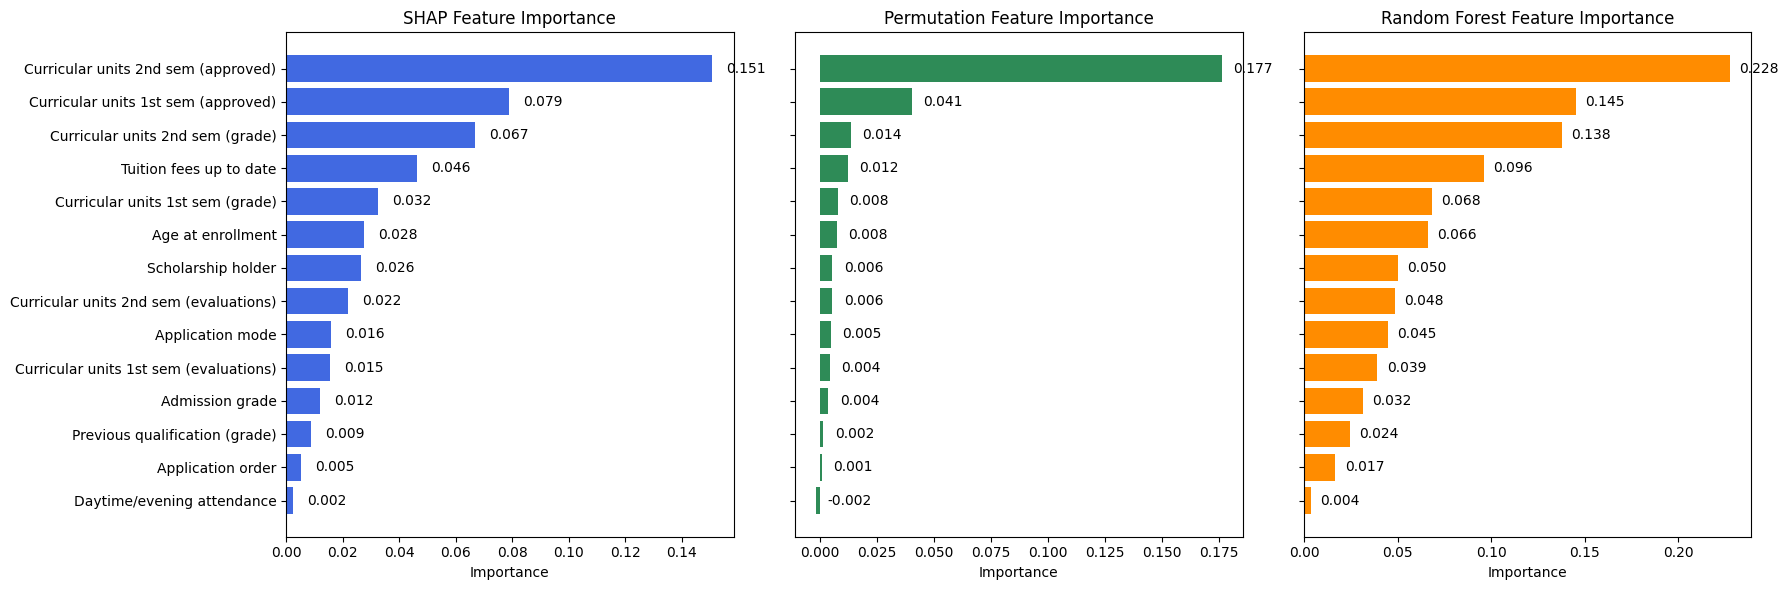

In [34]:
# Data
shap_importance = shap_importance_df['SHAP'].tolist()
permutation_importance = perm_importance_df['Permutation'].tolist()
random_forest_importance = importance_df['Random Forest'].tolist()

# Reverse lists for better visualization
features = features[::-1]
shap_importance = shap_importance[::-1]
permutation_importance = permutation_importance[::-1]
random_forest_importance = random_forest_importance[::-1]

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Function to add numbers on bars
def add_values(ax, bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                f"{width:.3f}", va='center', fontsize=10)

# SHAP Importance Plot
bars1 = axes[0].barh(features, shap_importance, color='royalblue')
axes[0].set_title("SHAP Feature Importance")
axes[0].set_xlabel("Importance")
add_values(axes[0], bars1)

# Permutation Importance Plot
bars2 = axes[1].barh(features, permutation_importance, color='seagreen')
axes[1].set_title("Permutation Feature Importance")
axes[1].set_xlabel("Importance")
add_values(axes[1], bars2)

# Random Forest Importance Plot
bars3 = axes[2].barh(features, random_forest_importance, color='darkorange')
axes[2].set_title("Random Forest Feature Importance")
axes[2].set_xlabel("Importance")
add_values(axes[2], bars3)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.savefig("features_importance.png")
plt.show()